In [2]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
#import ot
from abc import ABC, abstractmethod
import ot
from scipy import linalg
from statistic.wasserstein_distance import WassersteinDistance, WassersteinDistanceDeviation


In [3]:
import pickle
def save_pkl(variable, name):
    name = name + '.pkl'
    output = open(name, 'wb')
    pickle.dump(variable, output)
    output.close()


In [4]:
curves=pd.read_pickle('data/curves_2_wind_100.pkl')
clusters_new=pd.read_pickle('data/clust_fin.pkl')

In [5]:
curves_tensors=[]
for curve in range (len(curves)):
  curves_tensors.append(torch.from_numpy(curves[curve]))

max_shape=np.max(np.unique(list(map(len, curves))))
new_curves=[]
for i in range(len(curves)):
    new=np.zeros((max_shape,3))
    new[:curves[i].shape[0],:3]=curves[i]
    new_curves.append(new)

In [6]:
clusters_1=[]
for i,cl in enumerate(clusters_new):
  s=pd.DataFrame(cl)
  s['label']=[i]*len(s)
  clusters_1.append(s)
    
res_1=pd.concat(clusters_1)
res_1=res_1.drop_duplicates(0)
res_1=res_1.sort_values(0)

labels=np.array(res_1['label'])
labels=torch.Tensor(labels[:-1])

In [7]:
np.unique(labels,return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32),
 array([1051, 1113,  245,  413,  440, 1294,  312], dtype=int64))

In [8]:
tensor_set=torch.stack([torch.Tensor(i) for i in new_curves[:-1]])
data_set=data_utils.TensorDataset(tensor_set,labels)
train_loader=data_utils.DataLoader(data_set,batch_size=16,shuffle=True)

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(input.size(0),*self.shape)


In [10]:
dimZ = 200 # Considering face reconstruction task, which size of representation seems reasonable?
batch_size=1

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        def init_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)
        
        self.encoder=nn.Sequential()
        self.encoder.add_module('linear1',nn.Linear(1*2236*3,500))
        self.encoder.add_module('relu_1',nn.ReLU())
        
        self.encoder.add_module('linear2',nn.Linear(500,100))
        self.encoder.add_module('active1',nn.Sigmoid())
        self.encoder.apply(init_weights)
    def forward(self, x):

      latent_code =self.encoder(x)


      return latent_code

In [11]:
!nvidia-smi

Sat May  2 18:06:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:02:00.0 Off |                  N/A |
| 12%   45C    P5    19W / 230W |    682MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:03:00.0 Off |                  N/A |
|  0%   38C    P8    10W / 230W |     11MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [12]:
# decoder
# Create MSE loss function
device = torch.device('cuda:2')
criterion = torch.nn.MSELoss()
#Encoder().cuda()#
autoencoder =torch.load('model/weights_clusters/model_simple_auto__clust_100.ckpt')
autoencoder.load_state_dict(torch.load('model/weights_clusters/params_model_simple_auto_clust_100.ckpt', map_location=device))
# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(),lr=1e-3)

In [13]:

dist=WassersteinDistance(2)

  0%|          | 0/305 [00:00<?, ?it/s]

0


100%|██████████| 305/305 [05:26<00:00,  1.07s/it]
/home/e_borisov/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss:  0.020104390849651526


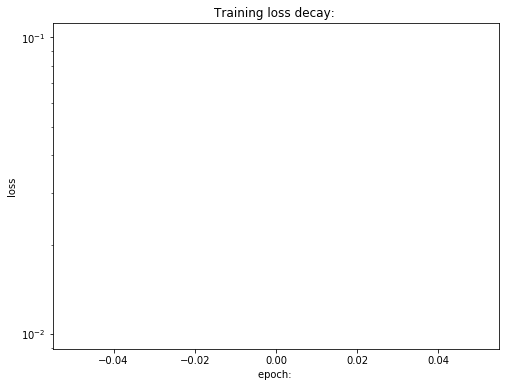

  0%|          | 0/305 [00:00<?, ?it/s]

1


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]

Loss:  0.017913929202898395


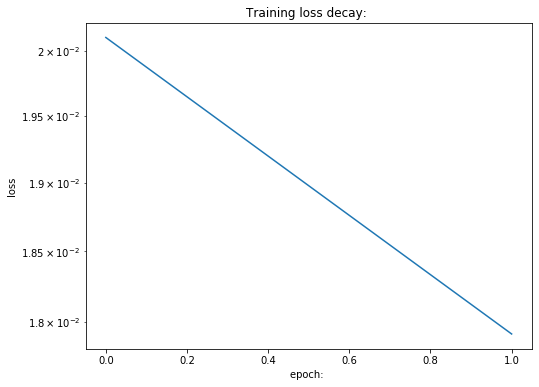

  0%|          | 0/305 [00:00<?, ?it/s]

2


100%|██████████| 305/305 [05:11<00:00,  1.02s/it]


Loss:  0.022116975385995066


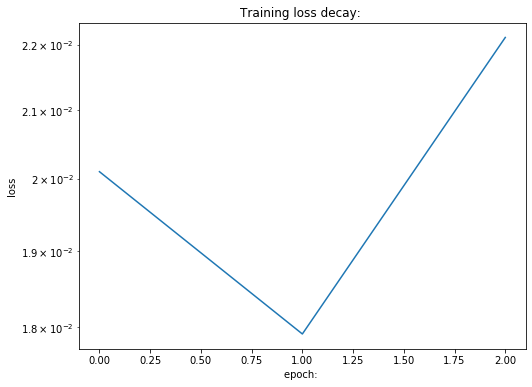

  0%|          | 0/305 [00:00<?, ?it/s]

3


100%|██████████| 305/305 [05:17<00:00,  1.04s/it]

Loss:  0.026896815305636777


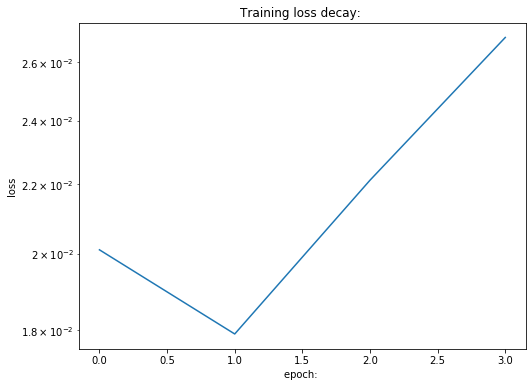

4


100%|██████████| 305/305 [05:26<00:00,  1.07s/it]


Loss:  0.025896450104381692


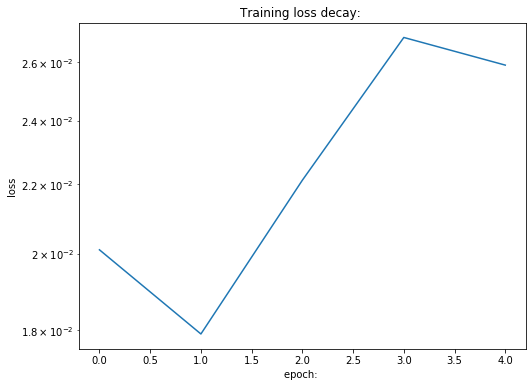

  0%|          | 0/305 [00:00<?, ?it/s]

5


100%|██████████| 305/305 [05:17<00:00,  1.04s/it]


Loss:  0.03173283676345123


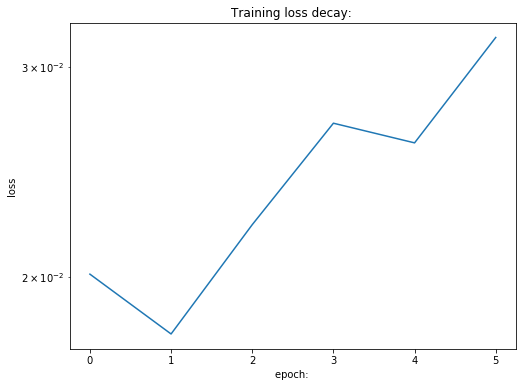

  0%|          | 0/305 [00:00<?, ?it/s]

6


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]

Loss:  0.02339493179260407


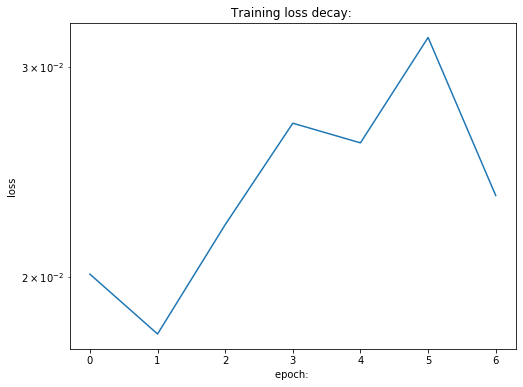

  0%|          | 0/305 [00:00<?, ?it/s]

7


100%|██████████| 305/305 [05:24<00:00,  1.06s/it]

Loss:  0.02613101131761107


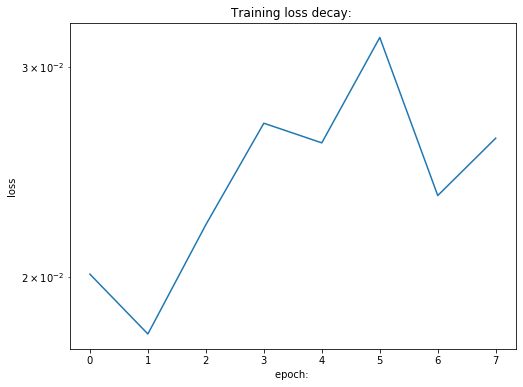

  0%|          | 0/305 [00:00<?, ?it/s]

8


100%|██████████| 305/305 [05:16<00:00,  1.04s/it]


Loss:  0.02483913529759718


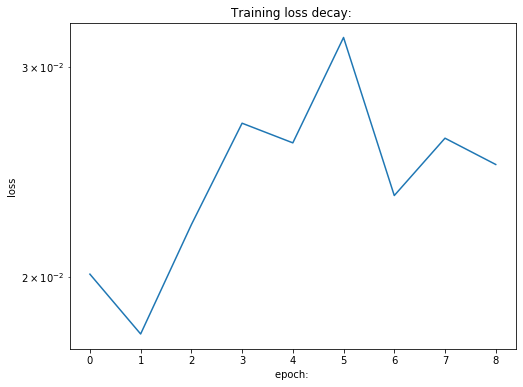

  0%|          | 0/305 [00:00<?, ?it/s]

9


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]

Loss:  0.029946016649315406


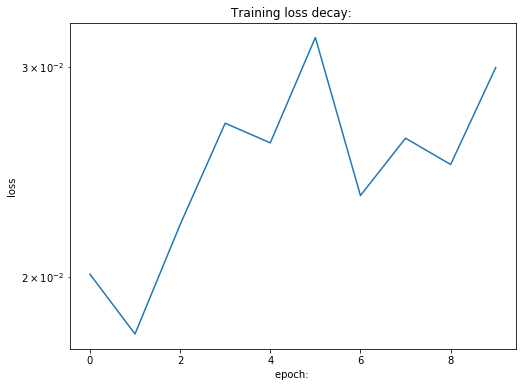

  0%|          | 0/305 [00:00<?, ?it/s]

10


100%|██████████| 305/305 [05:26<00:00,  1.07s/it]

Loss:  0.032282179090525075


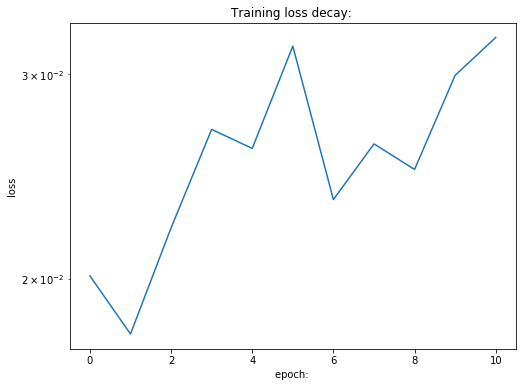

  0%|          | 0/305 [00:00<?, ?it/s]

11


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]

Loss:  0.024945845521880634


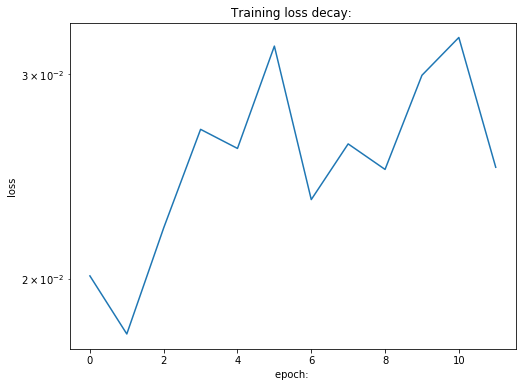

  0%|          | 0/305 [00:00<?, ?it/s]

12


100%|██████████| 305/305 [05:20<00:00,  1.05s/it]

Loss:  0.026703919276353988


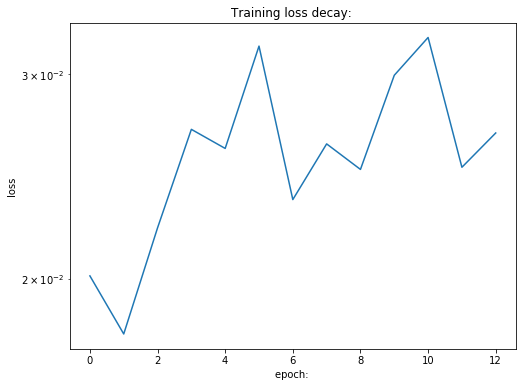

  0%|          | 0/305 [00:00<?, ?it/s]

13


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]


Loss:  0.031473105964458174


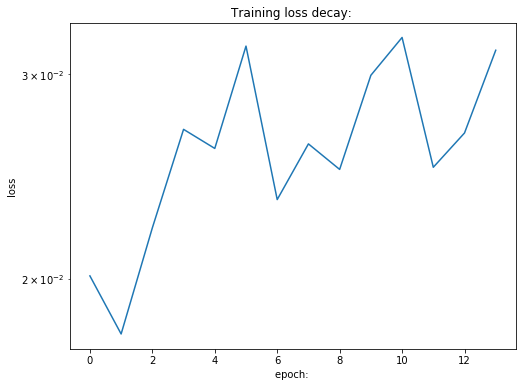

  0%|          | 0/305 [00:00<?, ?it/s]

14


100%|██████████| 305/305 [05:17<00:00,  1.04s/it]


Loss:  0.056493385388753044


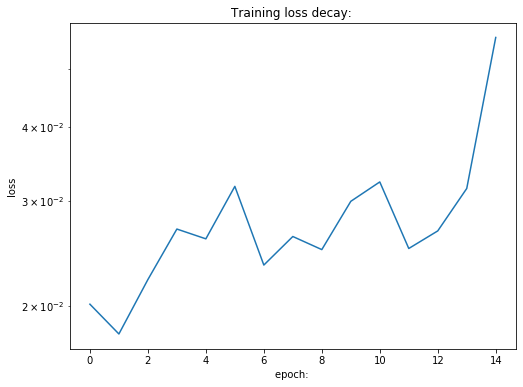

  0%|          | 0/305 [00:00<?, ?it/s]

15


100%|██████████| 305/305 [05:29<00:00,  1.08s/it]


Loss:  0.05445461598728338


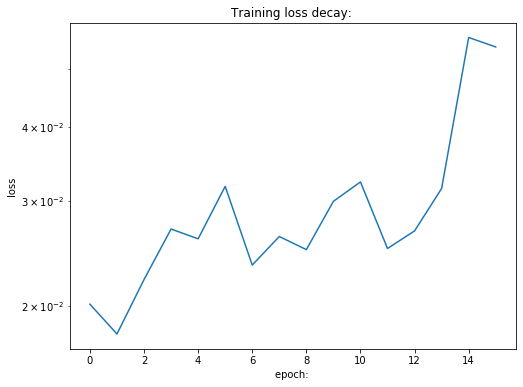

  0%|          | 0/305 [00:00<?, ?it/s]

16


100%|██████████| 305/305 [05:15<00:00,  1.04s/it]


Loss:  0.0495515699465378


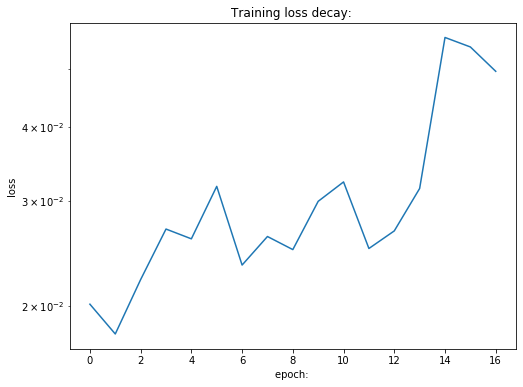

  0%|          | 0/305 [00:00<?, ?it/s]

17


100%|██████████| 305/305 [05:24<00:00,  1.06s/it]


Loss:  0.03298136931593431


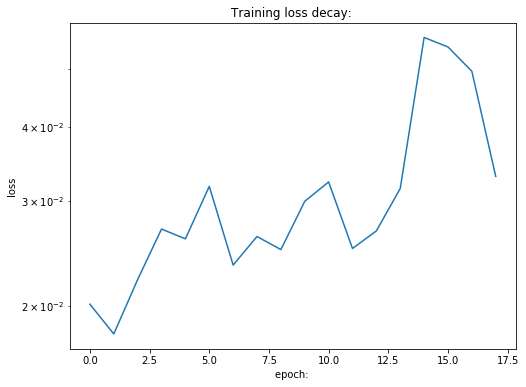

  0%|          | 0/305 [00:00<?, ?it/s]

18


100%|██████████| 305/305 [05:18<00:00,  1.04s/it]


Loss:  0.03367524694056626


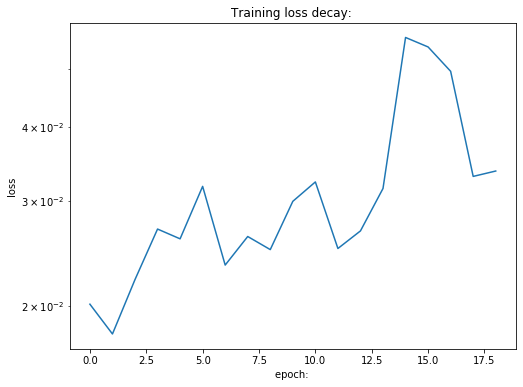

  0%|          | 0/305 [00:00<?, ?it/s]

19


100%|██████████| 305/305 [05:17<00:00,  1.04s/it]


Loss:  0.05034022065979966


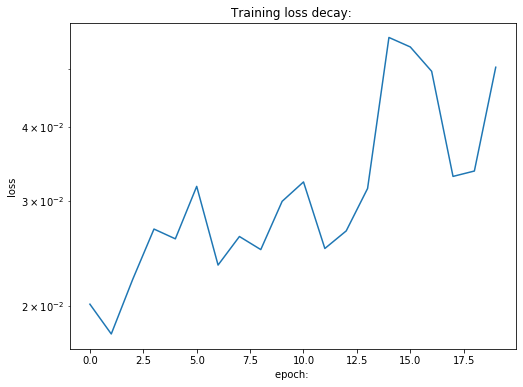

  0%|          | 0/305 [00:00<?, ?it/s]

20


100%|██████████| 305/305 [05:20<00:00,  1.05s/it]
/home/e_borisov/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss:  0.03674445614298818


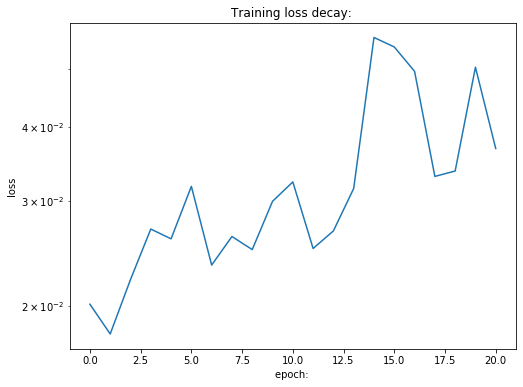

  0%|          | 0/305 [00:00<?, ?it/s]

21


100%|██████████| 305/305 [05:22<00:00,  1.06s/it]

Loss:  0.04159115833342319


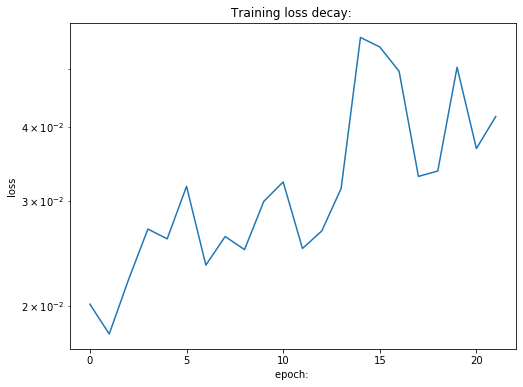

  0%|          | 0/305 [00:00<?, ?it/s]

22


100%|██████████| 305/305 [05:25<00:00,  1.07s/it]

Loss:  0.03984085555250014


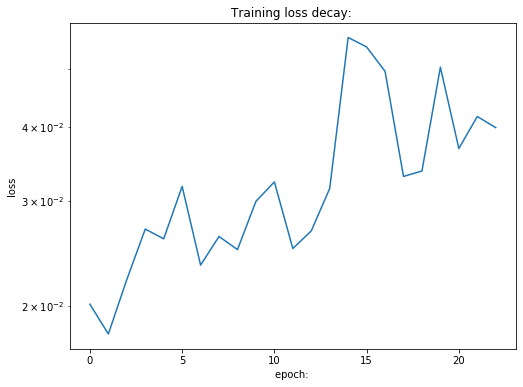

  0%|          | 0/305 [00:00<?, ?it/s]

23


100%|██████████| 305/305 [05:22<00:00,  1.06s/it]

Loss:  0.0515112276639803


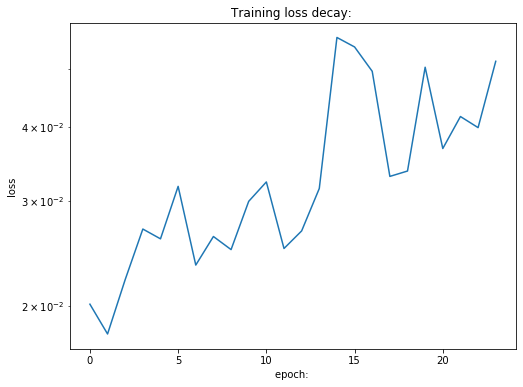

  0%|          | 0/305 [00:00<?, ?it/s]

24


100%|██████████| 305/305 [05:21<00:00,  1.05s/it]

Loss:  0.050286788235904545


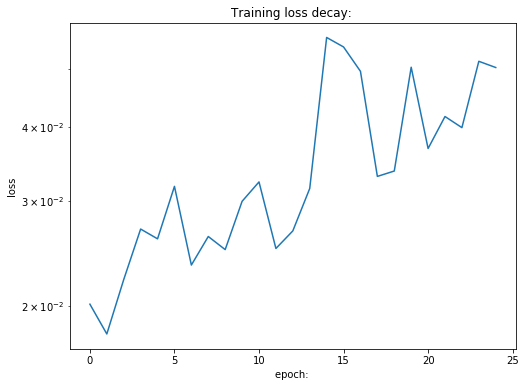

  0%|          | 0/305 [00:00<?, ?it/s]

25


100%|██████████| 305/305 [05:27<00:00,  1.07s/it]

Loss:  0.036041638455701


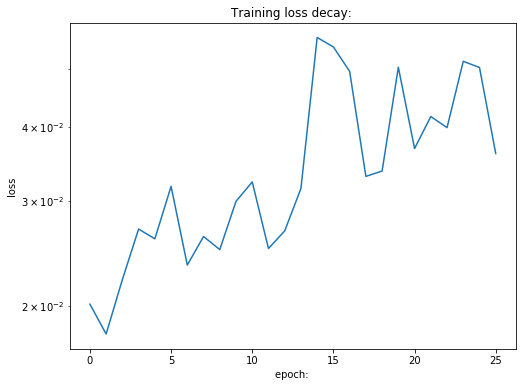

  0%|          | 0/305 [00:00<?, ?it/s]

26


100%|██████████| 305/305 [05:21<00:00,  1.05s/it]

Loss:  0.045289922838871344


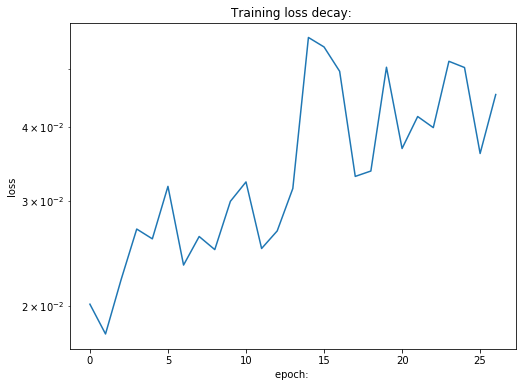

  0%|          | 0/305 [00:00<?, ?it/s]

27


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]


Loss:  0.06015328045947943


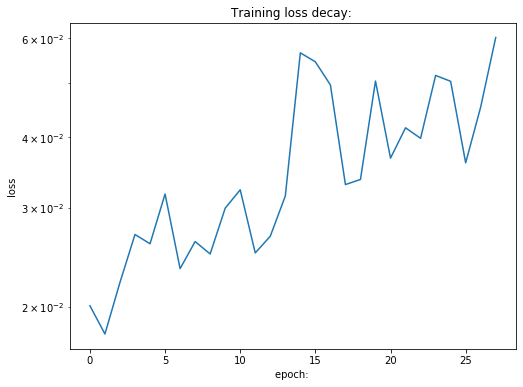

  0%|          | 0/305 [00:00<?, ?it/s]

28


100%|██████████| 305/305 [05:18<00:00,  1.04s/it]


Loss:  0.04515041103801666


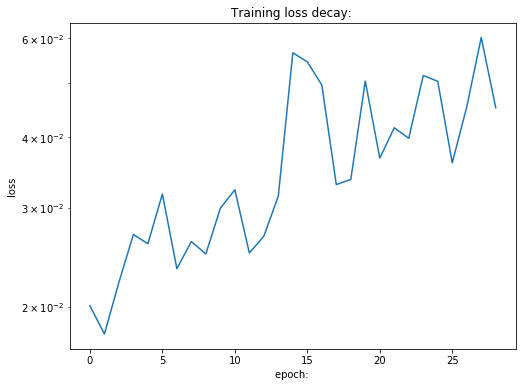

  0%|          | 0/305 [00:00<?, ?it/s]

29


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]


Loss:  0.03539868392058142


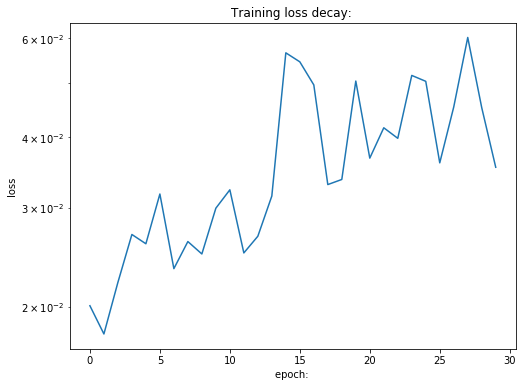

  0%|          | 0/305 [00:00<?, ?it/s]

30


100%|██████████| 305/305 [05:22<00:00,  1.06s/it]


Loss:  0.03201828147987109


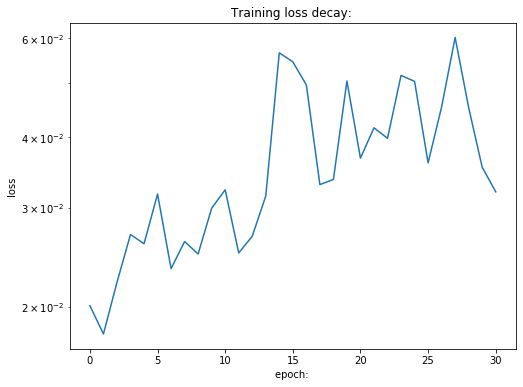

  0%|          | 0/305 [00:00<?, ?it/s]

31


100%|██████████| 305/305 [05:20<00:00,  1.05s/it]


Loss:  0.052500395448568306


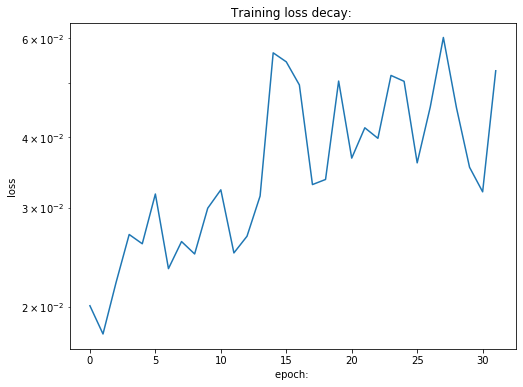

  0%|          | 0/305 [00:00<?, ?it/s]

32


100%|██████████| 305/305 [05:25<00:00,  1.07s/it]


Loss:  0.03085862534417928


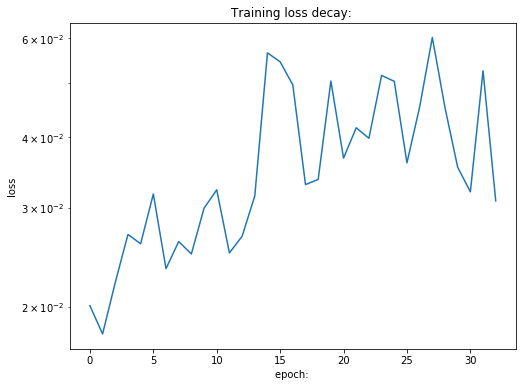

  0%|          | 0/305 [00:00<?, ?it/s]

33


100%|██████████| 305/305 [05:24<00:00,  1.06s/it]


Loss:  0.03886981960398845


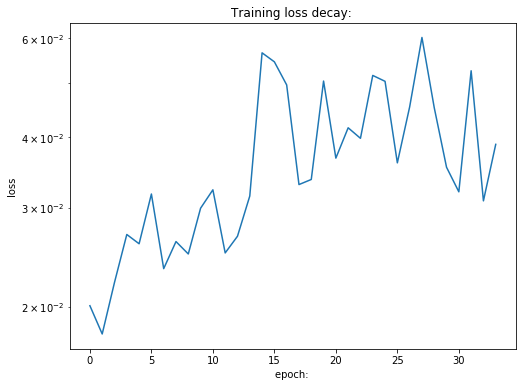

  0%|          | 0/305 [00:00<?, ?it/s]

34


100%|██████████| 305/305 [05:16<00:00,  1.04s/it]


Loss:  0.04882458414421936


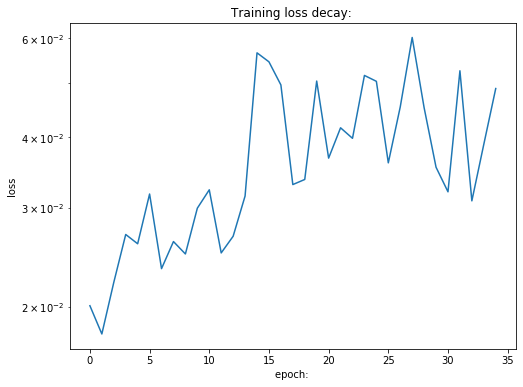

  0%|          | 0/305 [00:00<?, ?it/s]

35


100%|██████████| 305/305 [05:21<00:00,  1.06s/it]


Loss:  0.03726277979251983


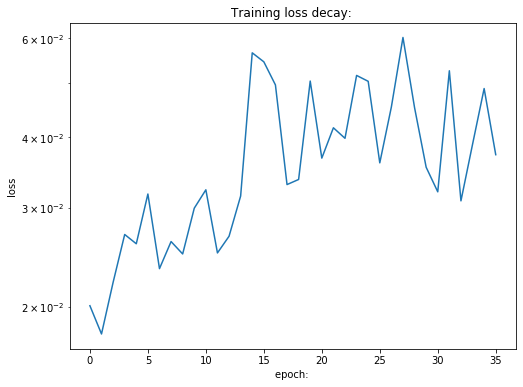

  0%|          | 0/305 [00:00<?, ?it/s]

36


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]


Loss:  0.047098312437645125


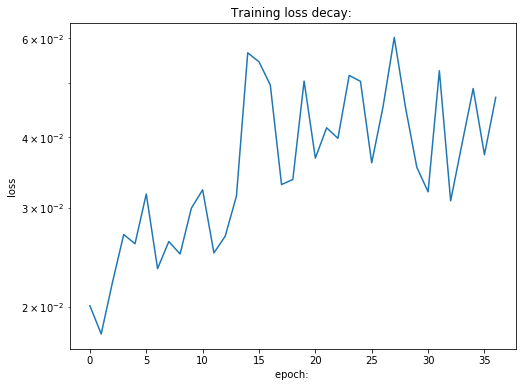

  0%|          | 0/305 [00:00<?, ?it/s]

37


100%|██████████| 305/305 [05:17<00:00,  1.04s/it]


Loss:  0.04834252545055633


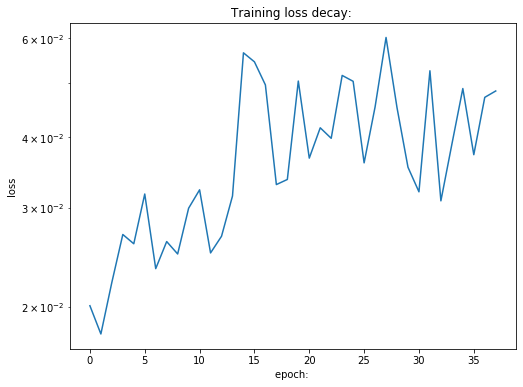

  0%|          | 0/305 [00:00<?, ?it/s]

38


100%|██████████| 305/305 [05:22<00:00,  1.06s/it]


Loss:  0.04432878807302632


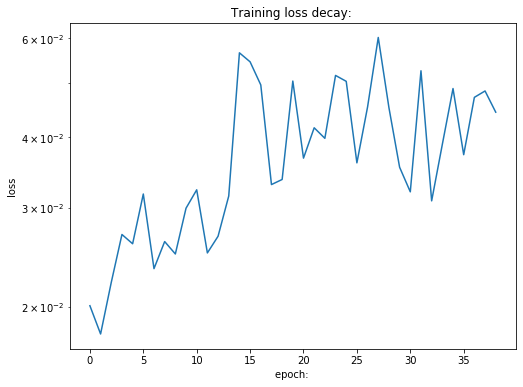

  0%|          | 0/305 [00:00<?, ?it/s]

39


100%|██████████| 305/305 [05:20<00:00,  1.05s/it]


Loss:  0.05314520943884879


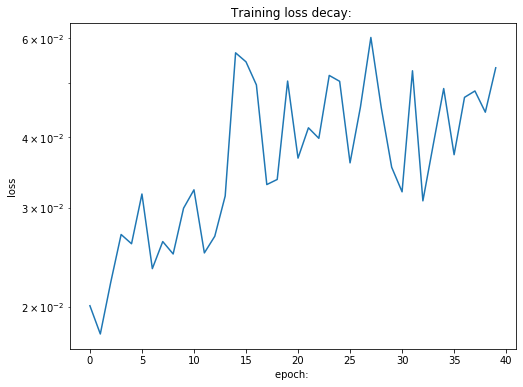

  0%|          | 0/305 [00:00<?, ?it/s]

40


100%|██████████| 305/305 [05:15<00:00,  1.03s/it]
/home/e_borisov/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss:  0.07986016055355931


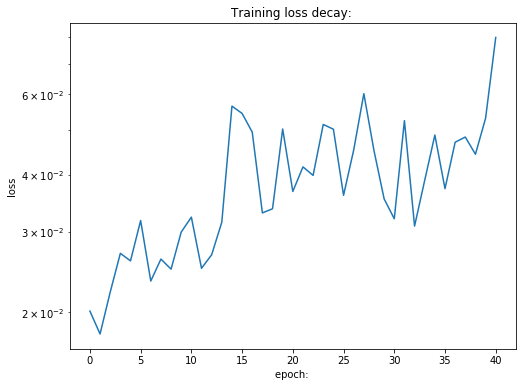

  0%|          | 0/305 [00:00<?, ?it/s]

41


100%|██████████| 305/305 [05:18<00:00,  1.04s/it]


Loss:  0.04382335265978192


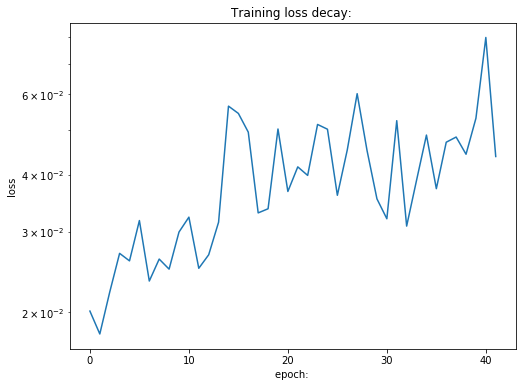

  0%|          | 0/305 [00:00<?, ?it/s]

42


100%|██████████| 305/305 [05:30<00:00,  1.08s/it]


Loss:  0.08324582641343482


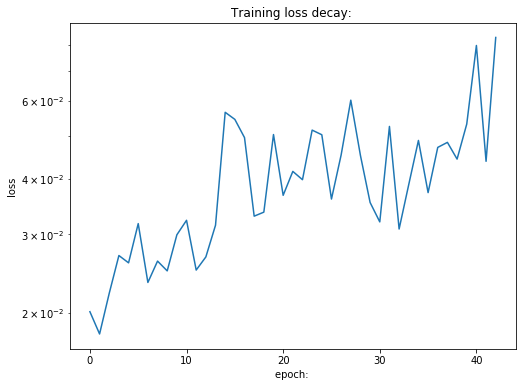

  0%|          | 0/305 [00:00<?, ?it/s]

43


100%|██████████| 305/305 [05:24<00:00,  1.06s/it]


Loss:  0.0482312387886089


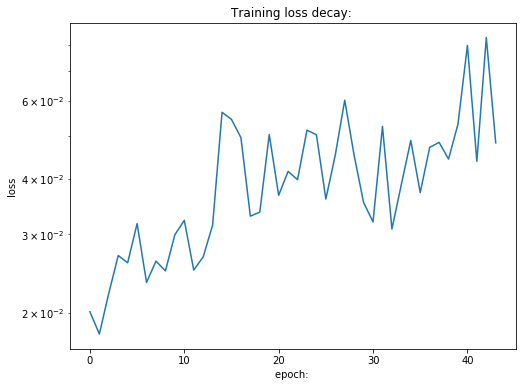

  0%|          | 0/305 [00:00<?, ?it/s]

44


100%|██████████| 305/305 [05:19<00:00,  1.05s/it]


Loss:  0.05105386882818178


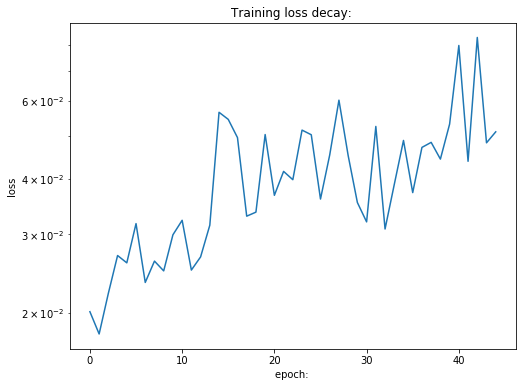

  0%|          | 0/305 [00:00<?, ?it/s]

45


100%|██████████| 305/305 [05:23<00:00,  1.06s/it]


Loss:  0.03561563004146032


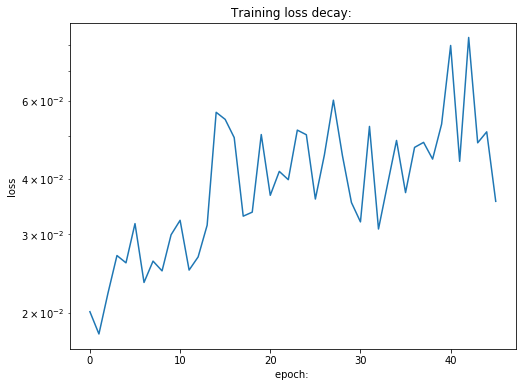

  0%|          | 0/305 [00:00<?, ?it/s]

46


100%|██████████| 305/305 [05:18<00:00,  1.04s/it]


Loss:  0.05254224008790693


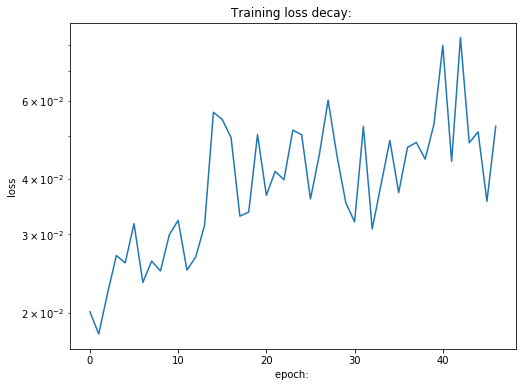

  0%|          | 0/305 [00:00<?, ?it/s]

47


100%|██████████| 305/305 [05:21<00:00,  1.05s/it]


Loss:  0.04584244541103875


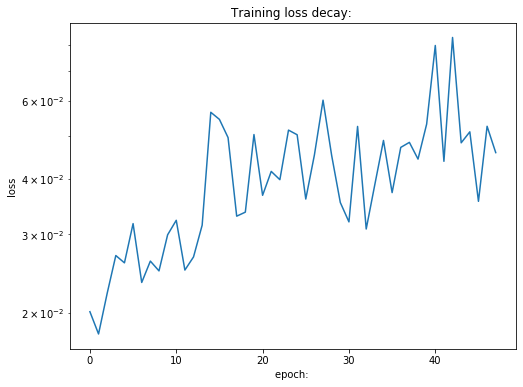

  0%|          | 0/305 [00:00<?, ?it/s]

48


100%|██████████| 305/305 [05:08<00:00,  1.01s/it]


Loss:  0.03601310512323432


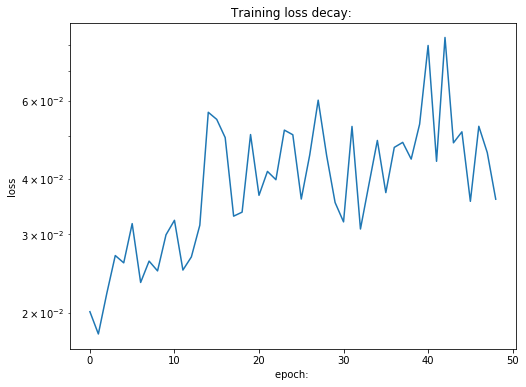

  0%|          | 0/305 [00:00<?, ?it/s]

49


100%|██████████| 305/305 [05:15<00:00,  1.04s/it]


Loss:  0.05651899376269686


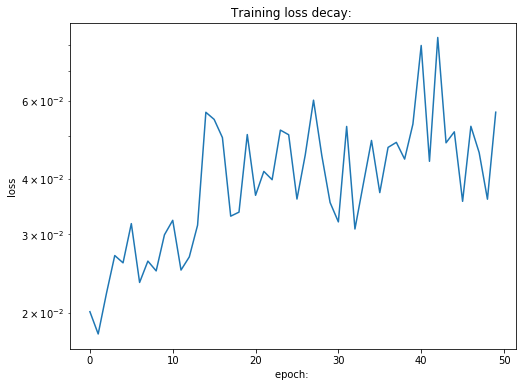

In [25]:
from tqdm import tqdm
image_progress=[]
loss_history=[]
for i in range(50):
    print(i)
    autoencoder.train(True)
    loss_epoch=[]
    for x_batch,y_batch in tqdm(train_loader):
        results=[]
        for batch in x_batch:
          x_batch_new=batch.reshape(1,-1)
         # print(x_batch_new.shape)
          x_batch_new=Variable(x_batch_new).cuda()
          res=autoencoder(x_batch_new)
          results.append(res)

        a=np.random.randint(0,len(x_batch),4)
        euclide=torch.norm(results[a[0]]-results[a[1]],p=2).type(torch.DoubleTensor)
        euclide_1=torch.norm(results[a[2]]-results[a[3]],p=2).type(torch.DoubleTensor)
        clusters=[y_batch[0],y_batch[1],y_batch[2],y_batch[3]]
        distance=torch.tensor(dist(x_batch[a[0]],x_batch[a[1]])).cuda()
        distance_1=torch.tensor(dist(x_batch[a[2]],x_batch[a[3]])).cuda()
        if clusters[0]==clusters[1]:
          var=0.7
        else:
          var=-0.1
        if clusters[2]==clusters[3]:
          var_1=0.7
        else:
          var_1=-0.1

        loss_1=criterion(euclide,distance)
        loss_2=criterion(euclide_1,distance_1).double()
        
        loss=(loss_1+euclide*var)+(loss_2+euclide_1*var_1)
#         print(loss.double())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch.append(loss.data.cpu().numpy())
    if i%20==0:
      torch.save(autoencoder, 'model_simple_auto1'+str(i)+'.ckpt')
      torch.save(autoencoder.state_dict(), 'params_model_simple_auto1'+str(i)+'.ckpt')

    autoencoder.train(False)    
    loss_history.append(np.mean(loss_epoch))
    
    print('Loss: ',np.mean(loss_epoch))
    plt.figure(figsize=(8, 6))
    plt.title("Training loss decay: ")
    plt.xlabel("epoch: ")
    plt.ylabel("loss")
    plt.semilogy(loss_history, label = 'training loss')
    plt.show()

In [16]:
np.mean(loss_epoch)

-0.07670895940580484